In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator  # interval in axis of charts
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
import warnings

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore')

In [2]:
import os

for dirname, _, filenames in os.walk('input/'):
    for filename in filenames:
        print(f'./{dirname}/{filename}')

./input/real_estate_price_prediction_moscow/sample_submission.csv
./input/real_estate_price_prediction_moscow/test.csv
./input/real_estate_price_prediction_moscow/train.csv


In [3]:
TRAIN_DATASET_PATH = './input/real_estate_price_prediction_moscow/train.csv'
TEST_DATASET_PATH = './input/real_estate_price_prediction_moscow/test.csv'

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850


In [5]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B


In [7]:
print(f'Strings in train: {train_df.shape[0]}')
print(f'Strings in test: {test_df.shape[0]}')

Strings in train: 10000
Strings in test: 5000


In [8]:
# check the number of columns (train have col=Price --> target)
train_df.shape[1] - test_df.shape[1] == 1

True

In [9]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
def chart_scatter_standart(feature_1, feature_2, title='', x_locator=20, y_locator=50):
    plt.figure(figsize=(16, 8))
    plt.scatter(train_df[feature_1], train_df[feature_2], s=5, color='darkred')
    plt.tick_params(axis='both',which='major',labelsize=14, color='red')
    ax=plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(x_locator))
    ax.yaxis.set_major_locator(MultipleLocator(y_locator))
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.title(title, fontsize=18)
    plt.grid(color='lavender')
    plt.show()

### 1. EDA

In [11]:
# error corection in titles and delete id исправление ошибок
train_df.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)        
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850


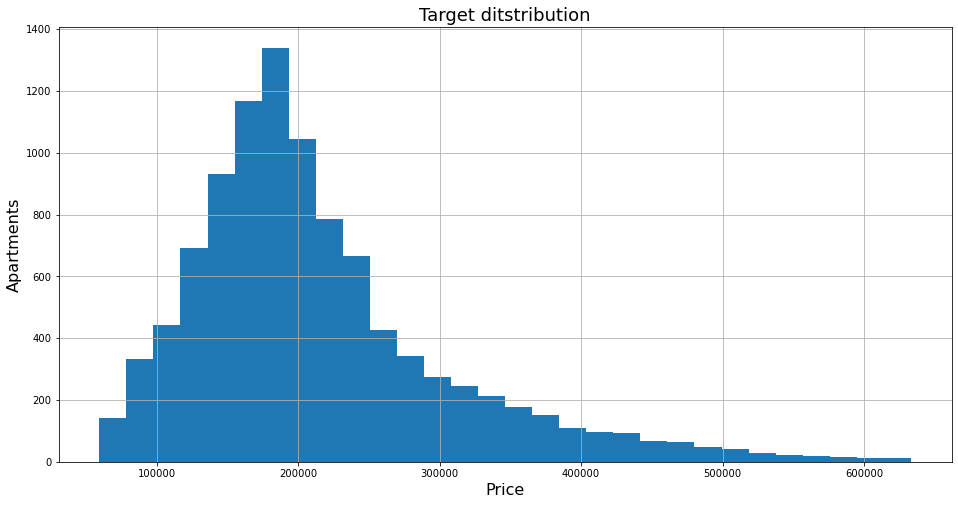

In [12]:
plt.figure(figsize=(16, 8))
train_df['Price'].hist(bins=30)
plt.xlabel('Price', fontsize=16)
plt.ylabel('Apartments', fontsize=16)
plt.title('Target ditstribution', fontsize=18)
plt.show()

#### ~ Quantitative variables

In [13]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### ~ Nominative variables

In [14]:
train_df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [15]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [16]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [17]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [18]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Processing of emissions

#### Rooms

In [19]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [20]:
# create Rooms_outlier
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.groupby(['Rooms_outlier'])['Rooms'].value_counts()

Rooms_outlier  Rooms
0              2.0      3880
               1.0      3705
               3.0      2235
               4.0       150
               5.0        18
1              0.0         8
               10.0        2
               6.0         1
               19.0        1
Name: Rooms, dtype: int64

In [21]:
# replacement 0 by 1 room
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1

# replacement rooms >= 6
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()

train_df['Rooms'] = train_df['Rooms'].astype(int)

#### HouseFloor

In [22]:
# if HouseFloor == 0 --> HouseFloor = Floor
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df[train_df['HouseFloor'] == 0]['Floor']
train_df['HouseFloor'] = train_df['HouseFloor'].astype(int)

#### Floor

In [23]:
# if Floor > HouseFloor --> Floor = HouseFloor
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] \
= train_df[train_df['Floor'] > train_df['HouseFloor']]['HouseFloor']

#### HouseYear

In [24]:
train_df.loc[(train_df['HouseYear'] < 1900), 'HouseYear'] = int(train_df['HouseYear'].median())
train_df.loc[(train_df['HouseYear'] > 2020), 'HouseYear'] = 2020

#### Square

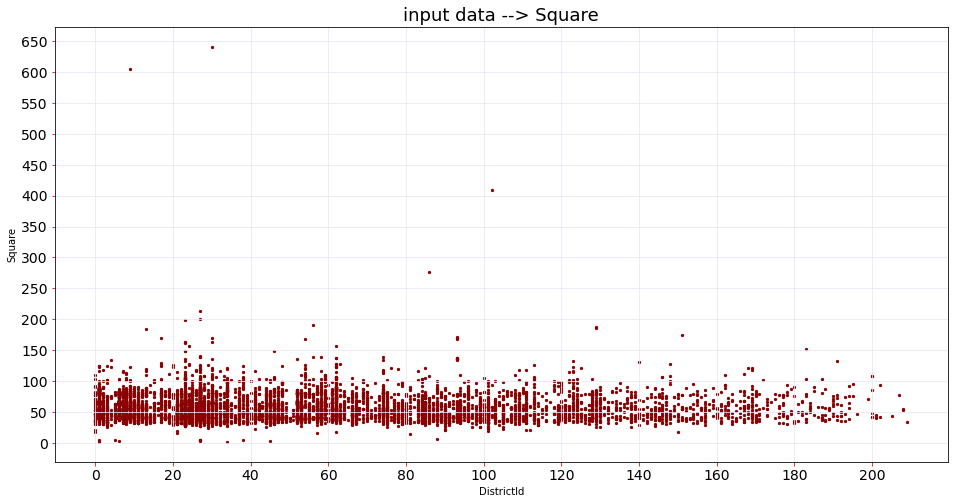

In [25]:
chart_scatter_standart('DistrictId', 'Square', 'input data --> Square')

In [26]:
# Exclude with help chart emissions > 250
train_df.loc[train_df['Square'] > 250, 'Square'] = train_df['Square'].median()

# The smallest apartments in Moscow --> 8.3 m^2 (to use 8)
train_df.loc[train_df['Square'] < 8, 'Square'] = 8
train_df['Square'] = train_df['Square'].round().astype(int)
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3,115,NaN,10.0,4,10,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1,40,23.169223,8.0,7,8,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3,78,47.671972,10.0,2,17,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1,40,NaN,1.0,10,22,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2,64,38.562517,9.0,16,16,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2,49,33.272626,6.0,3,12,1981,0.300323,...,B,52,10311,6,NaN,1,9,B,119367.455796,0
9996,16265,27,2,64,37.038420,9.0,13,13,1977,0.072158,...,B,2,629,1,NaN,0,0,A,199715.148807,0
9997,2795,178,1,30,16.555363,5.0,3,5,1958,0.460556,...,B,20,4386,14,NaN,1,5,B,165953.912580,0
9998,14561,21,1,32,22.326870,5.0,3,9,1969,0.194489,...,B,47,8004,3,125.0,3,5,B,171842.411855,0


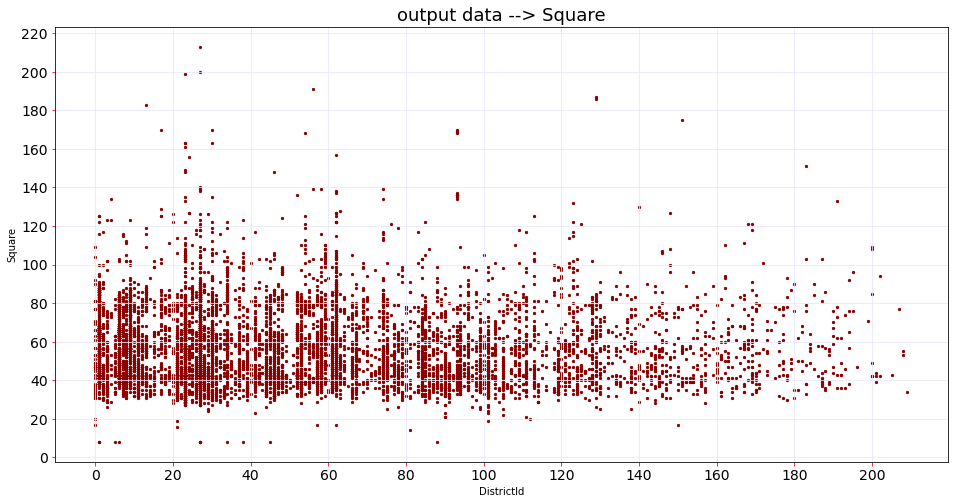

In [27]:
chart_scatter_standart('DistrictId', 'Square', 'output data --> Square', 20, 20)

#### KitchenSquare

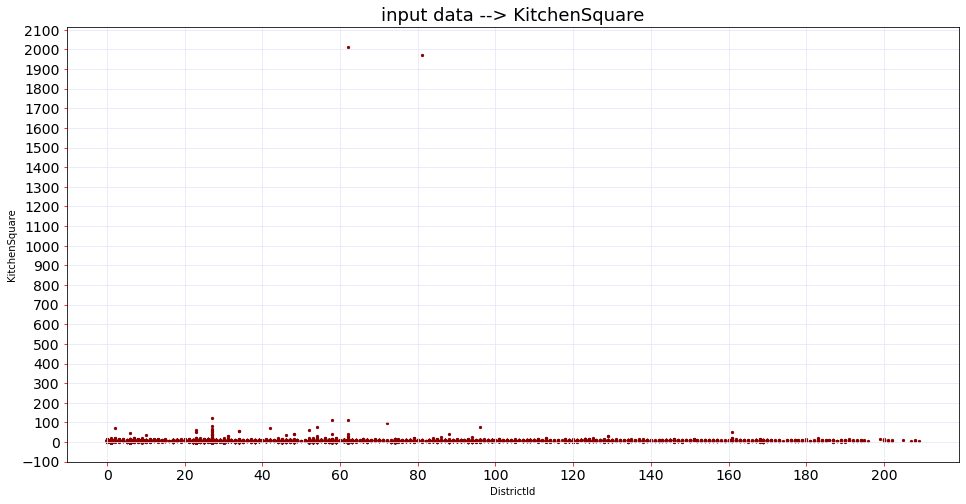

In [28]:
chart_scatter_standart('DistrictId', 'KitchenSquare', 'input data --> KitchenSquare', 20, 100)

In [29]:
print('before rows: ', train_df.shape[0])
train_df = train_df[train_df['KitchenSquare'] < 200]
train_df['KitchenSquare'] = train_df['KitchenSquare'].round(0).astype(int)
print('after rows: ', train_df.shape[0])

before rows:  10000
after rows:  9998


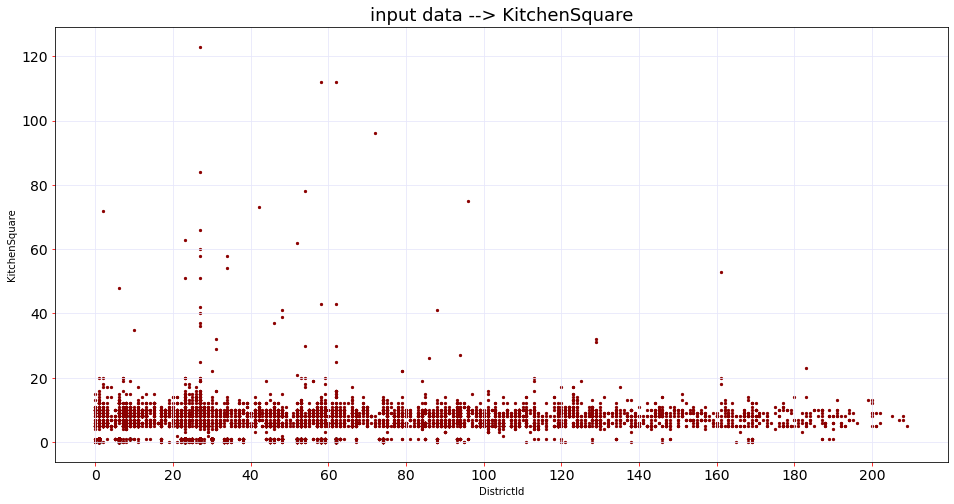

In [30]:
chart_scatter_standart('DistrictId', 'KitchenSquare', 'input data --> KitchenSquare', 20, 20)

#### LifeSquare

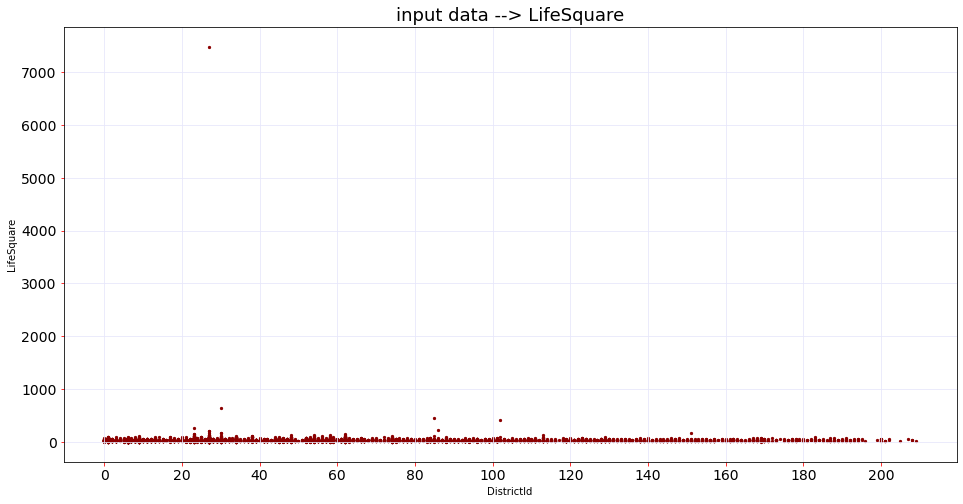

In [31]:
chart_scatter_standart('DistrictId', 'LifeSquare', 'input data --> LifeSquare', 20, 1000)

In [32]:
# find LifeSquare > Square - KitchenSquare
train_df.loc[train_df['LifeSquare'] > train_df['Square'] - train_df['KitchenSquare'] - 3, 'LifeSquare'] \
= train_df['Square'] - train_df['KitchenSquare'] - 3

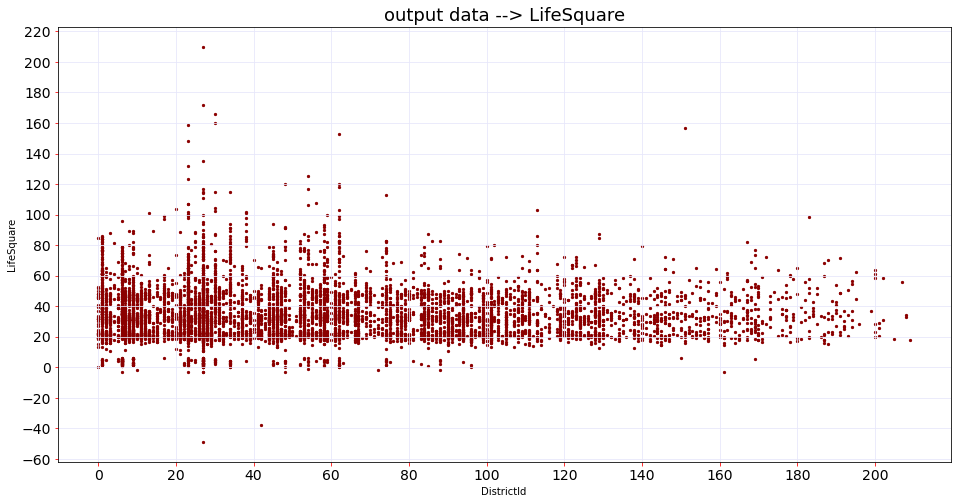

In [33]:
chart_scatter_standart('DistrictId', 'LifeSquare', 'output data --> LifeSquare', 20, 20)

### 3. NaN

In [34]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price,Rooms_outlier
count,9998.000000,9998.000000,9998.000000,9998.000000,7885.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,5201.000000,9998.000000,9998.000000,9998.000000,9998.000000
mean,8382.150630,50.396579,1.887778,56.146329,34.942451,5.876075,7.944589,12.854571,1984.870274,0.118873,24.688738,5352.636527,8.040708,1143.000192,1.319164,4.231546,214160.301755,0.001200
std,4858.691936,43.590723,0.811422,19.014157,16.699580,5.174532,5.227727,6.535325,18.415717,0.119031,17.532819,4006.922053,23.834019,1021.592144,1.492958,4.806603,92869.201646,0.034625
min,0.000000,0.000000,1.000000,8.000000,-49.000000,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000
25%,4168.500000,20.000000,1.000000,42.000000,22.666701,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153898.495433,0.000000
50%,8393.500000,35.500000,2.000000,53.000000,32.306154,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192290.039215,0.000000
75%,12590.750000,75.000000,2.000000,66.000000,44.345501,9.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249161.507295,0.000000
max,16798.000000,209.000000,5.000000,213.000000,210.000000,123.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000


#### LifeSquare

Find ratio lifeSquare / Square; (by districts) \
Ratio will use for replace NaN LifeSquare

In [35]:
# Select rows with normal 'LifeSquare', where LifeSquare <= Square and 'LifeSquare' != NaN
df_ls = train_df[~(train_df['LifeSquare'].isna())]
df_ls.shape

(7885, 21)

In [36]:
# Create ratio lifeSquare / square (for replace NaN LifeSquare) (by DistrictId)
district_sq_mean = df_ls.groupby('DistrictId').mean()['Square']
district_lsq_mean = df_ls.groupby('DistrictId').mean()['LifeSquare']

k_mean_life_square = district_lsq_mean / district_sq_mean

k_mean_life_square = pd.DataFrame(k_mean_life_square)
k_mean_life_square.rename(columns={0: 'K_LS_S'}, inplace=True)

In [37]:
train_df = train_df.merge(k_mean_life_square, on=['DistrictId'])

In [38]:
train_df.loc[(train_df['LifeSquare'].isna()), 'LifeSquare'] = \
train_df.loc[(train_df['LifeSquare'].isna()), 'Square'] * train_df.loc[(train_df['LifeSquare'].isna()), 'K_LS_S']
train_df['LifeSquare'] = train_df['LifeSquare'].round().astype(int)

#### Healthcare_1

In [39]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [40]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price,Rooms_outlier,K_LS_S
count,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000
mean,8382.150630,50.396579,1.887778,56.146329,36.274455,5.876075,7.944589,12.854571,1984.870274,0.118873,24.688738,5352.636527,8.040708,1026.409682,1.319164,4.231546,214160.301755,0.001200,0.644796
std,4858.691936,43.590723,0.811422,19.014157,16.270062,5.174532,5.227727,6.535325,18.415717,0.119031,17.532819,4006.922053,23.834019,746.726701,1.492958,4.806603,92869.201646,0.034625,0.053374
min,0.000000,0.000000,1.000000,8.000000,-49.000000,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.434036
25%,4168.500000,20.000000,1.000000,42.000000,24.000000,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153898.495433,0.000000,0.607975
50%,8393.500000,35.500000,2.000000,53.000000,33.000000,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192290.039215,0.000000,0.634166
75%,12590.750000,75.000000,2.000000,66.000000,46.000000,9.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249161.507295,0.000000,0.670299
max,16798.000000,209.000000,5.000000,213.000000,210.000000,123.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,0.784180


In [41]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Healthcare_2     0
Shops_1          0
Shops_2          0
Price            0
Rooms_outlier    0
K_LS_S           0
dtype: int64

#### ~ class DataPreprocessing

In [42]:
class DataPreprocessing:
    """Preparation of initial data"""
    
    def __init__(self):
        """Class parameters"""
        self.median = None
        
    def fit(self, X):
        """saving statistics"""
        # Calculation of medians
        self.medians = X.median()
        
    def transform(self, X):
        """data transformation"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']

        # HouseFloor, Floor
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = X[train_df['HouseFloor'] == 0]['Floor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X[X['Floor'] > X['HouseFloor']]['HouseFloor']
        
        #HouseYear
        X.loc[(X['HouseYear'] < 1900), 'HouseYear'] = int(X['HouseYear'].median())
        X.loc[(X['HouseYear'] > 2020), 'HouseYear'] = 2020

        # Healthcare_1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['Healthcare_1'].median()
            
        # Square
        ## Exclude with help chart emissions > 250
        X.loc[X['Square'] > 250, 'Square'] = X['Square'].median()

        ## The smallest apartments in Moscow --> 8.3 m^2 (to use 8)
        X.loc[X['Square'] < 8, 'Square'] = 8
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X = X[X['KitchenSquare'] < 200]
        X.loc[X['KitchenSquare'].isna(), 'KitchenSquare'] = X['KitchenSquare'].median()
        
        #LifeSquare
        X.loc[X['LifeSquare'] > (X['Square'] - X['KitchenSquare'] - 3), 'LifeSquare'] \
        = X['Square'] - X['KitchenSquare'] - 3
        
        ## Select rows with 'LifeSquare' != NaN
        X_ls = X[~(X['LifeSquare'].isna())]
        
        ## Create ratio lifeSquare / square (for replace NaN LifeSquare) (by DistrictId)
        district_sq_mean = X_ls.groupby('DistrictId').mean()['Square']
        district_lsq_mean = X_ls.groupby('DistrictId').mean()['LifeSquare']

        k_mean_life_square = district_lsq_mean / district_sq_mean

        k_mean_life_square = pd.DataFrame(k_mean_life_square)
        k_mean_life_square.rename(columns={0: 'K_LS_S'}, inplace=True)
        
        X = X.merge(k_mean_life_square, on=['DistrictId'])
        
        X.loc[(X['LifeSquare'].isna()), 'LifeSquare'] = \
        X.loc[(X['LifeSquare'].isna()), 'Square'] * X.loc[(X['LifeSquare'].isna()), 'K_LS_S']

        # round features
        X[['Square', 'KitchenSquare', 'LifeSquare']] = X[['Square', 'KitchenSquare', 'LifeSquare']].round()
        
        # type int
        X[['Rooms', 'HouseFloor', 'Square', 'KitchenSquare', 'LifeSquare']]\
        = train_df[['Rooms', 'HouseFloor', 'Square', 'KitchenSquare', 'LifeSquare']].astype(int)
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [43]:
train_df[['Ecology_2', 'Ecology_3', 'Shops_2']]

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,A
2,B,B,B
3,B,B,A
4,B,B,B
...,...,...,...
9993,B,B,B
9994,B,B,B
9995,B,B,B
9996,B,B,B


### 4. Building new features 

#### MeanSquareRooms

In [44]:
mean_square_rooms = train_df.groupby('DistrictId')[['Rooms', 'LifeSquare']].sum()
mean_square_rooms = pd.DataFrame((mean_square_rooms['LifeSquare'] / mean_square_rooms['Rooms']).round().astype(int))
mean_square_rooms.rename(columns={0: 'MeanSquareRooms'}, inplace=True)
train_df = train_df.merge(mean_square_rooms, on=['DistrictId'], how='left')

#### Dummies

In [45]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

#### DistrictSize, IsDistrictLarge

In [46]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
.rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})

In [47]:
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [48]:
train_df = pd.merge(train_df, district_size, on='DistrictId', how='left')

In [49]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,K_LS_S,MeanSquareRooms,DistrictSize
0,11809,27,3,115,73,10,4,10,2014,0.075424,...,0,900.0,0,0,1,305018.871089,0,0.634166,21,851
1,4717,27,1,44,28,0,2,2,1977,0.072158,...,1,900.0,0,0,0,135466.559958,0,0.634166,21,851
2,7757,27,2,59,45,11,12,12,1977,0.011654,...,0,900.0,0,0,1,138396.984612,0,0.634166,21,851
3,6846,27,1,52,33,6,13,17,1977,0.072158,...,1,900.0,0,0,0,155463.092033,0,0.634166,21,851
4,13726,27,1,48,23,1,1,1,1977,0.017647,...,0,900.0,0,0,1,130190.643579,0,0.634166,21,851


In [50]:
(train_df['DistrictSize'] > 100).value_counts()

True     5068
False    4930
Name: DistrictSize, dtype: int64

In [51]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

#### MedPriceByDistrict

In [52]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False)['Price'].median()\
.rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_district.head(10)

,DistrictId,Rooms,MedPriceByDistrict
0,0,1,142799.434052
1,0,2,176210.812334
2,0,3,300610.359425
3,1,1,146735.671740
4,1,2,202666.310126
5,1,3,244005.272380
6,1,4,277290.705058
7,2,1,174545.972737
8,2,2,215477.288974
9,2,3,323304.615000


In [53]:
med_price_by_district.shape

(667, 3)

In [54]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

#### MedPricebyFloorYear

In [55]:
def floor_to_cat(X):
    X['floor_cat'] = 0
    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat']  = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat']  = 4
    X.loc[X['Floor'] > 15, 'floor_cat']  = 5
    
    return X

In [76]:
def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['Floor_cat'].fillna(-1, inplace=True)
    
    return X

In [57]:
def year_to_cat(X):
    X['year_cat'] = 0
    
    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[X['HouseYear'] > 2010, 'year_cat'] = 6
    
    return X

In [67]:
def year_to_cat_pandas(X):
    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    
    return X

In [82]:
bins = [train_df['Floor'].min(), 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, include_lowest=True)

0         (3.0, 5.0]
1       (0.999, 3.0]
2        (9.0, 15.0]
3        (9.0, 15.0]
4       (0.999, 3.0]
            ...     
9993      (5.0, 9.0]
9994      (3.0, 5.0]
9995      (5.0, 9.0]
9996      (3.0, 5.0]
9997      (3.0, 5.0]
Name: Floor, Length: 9998, dtype: category
Categories (5, interval[float64, right]): [(0.999, 3.0] < (3.0, 5.0] < (5.0, 9.0] < (9.0, 15.0] < (15.0, 42.0]]

In [79]:
bins = [train_df['Floor'].min(), 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, include_lowest=True, labels=False)

0       1
1       0
2       3
3       3
4       0
       ..
9993    2
9994    1
9995    2
9996    1
9997    1
Name: Floor, Length: 9998, dtype: int64